## Regression with categorical predictors having multiple categories 

In [1]:
# reading in the libraries and functions that we will need as we do this work.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
import scipy.stats as st
import statsmodels.api as sm 
import pylab as py 

# here are some of the tools we will use for our analyses
from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

We'll use the Penguins data

In [2]:
penguins = pd.read_csv("https://webpages.charlotte.edu/mschuck1/classes/DTSC2301/Data/penguins.csv", na_values=['NA'])
# remove rows with missing data
penguins.dropna(inplace=True)
penguins.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [3]:
penguins['species'].value_counts()

species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

Note the above counts for the three different penguin types.  Seems like we might be able to use the species information to get better
    prediction for body mass.

In [4]:
# make indicator/dummy variables for species
# each species gets a different column
one_hot=pd.get_dummies(penguins['species'],dtype=int)
print(one_hot)
penguins=penguins.join(one_hot)
penguins.head()

     Adelie  Chinstrap  Gentoo
0         1          0       0
1         1          0       0
2         1          0       0
4         1          0       0
5         1          0       0
..      ...        ...     ...
339       0          1       0
340       0          1       0
341       0          1       0
342       0          1       0
343       0          1       0

[333 rows x 3 columns]


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,Adelie,Chinstrap,Gentoo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,1,0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,1,0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,1,0,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,1,0,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007,1,0,0


Let's look at a couple of plots using species

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

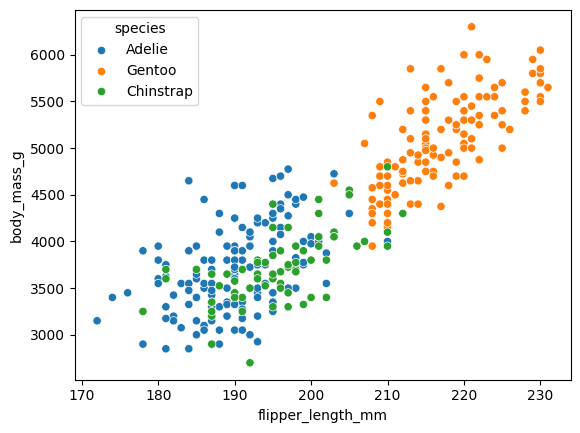

In [5]:
sns.scatterplot(data=penguins, x="flipper_length_mm", y="body_mass_g", hue="species")

Looks like the curvature we saw from this plots was really about the species of the penguins.

<Axes: xlabel='bill_length_mm', ylabel='body_mass_g'>

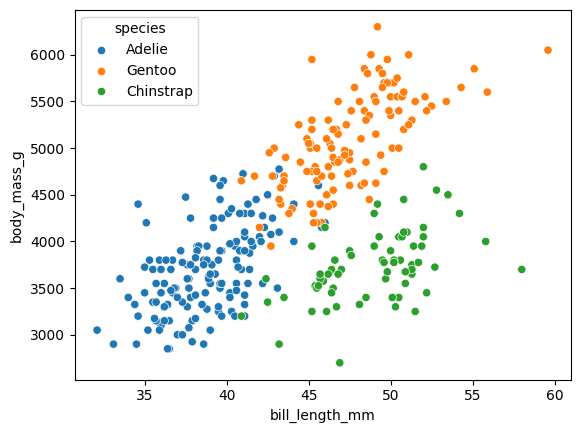

In [6]:
sns.scatterplot(data=penguins, x="bill_length_mm", y="body_mass_g", hue="species")



<Axes: xlabel='bill_depth_mm', ylabel='body_mass_g'>

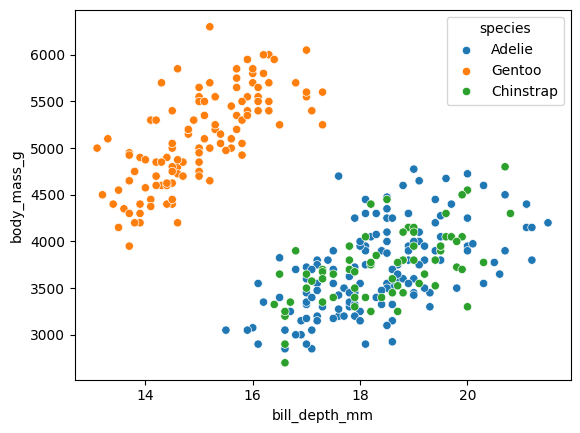

In [7]:
sns.scatterplot(data=penguins, x="bill_depth_mm", y="body_mass_g", hue="species")

Seems like we have different relations with body mass depending upon species, let's create some interactions.  In what we do below, we will use *Gentoo* species
as our baseline and *Adelie* and *Chinstrap* are relative to it.

In [8]:
# interactions of bill_depth_mm with Species
penguins['billDepth_Adelie'] = penguins['bill_depth_mm']*penguins['Adelie']
penguins['billDepth_Chinstrap'] = penguins['bill_depth_mm']*penguins['Chinstrap']

# interactions of flipper_length_mm with Species
penguins['flipper_Adelie'] = penguins['flipper_length_mm']*penguins['Adelie']
penguins['flipper_Chinstrap'] = penguins['flipper_length_mm']*penguins['Chinstrap']

# interactions of bill_length_mm with Species
penguins['billLength_Adelie'] = penguins['bill_length_mm']*penguins['Adelie']
penguins['billLength_Chinstrap'] = penguins['bill_length_mm']*penguins['Chinstrap']

#### Regression 1: Quantitative Predictors Only

Root Mean Squared Error: 390.63708572458495


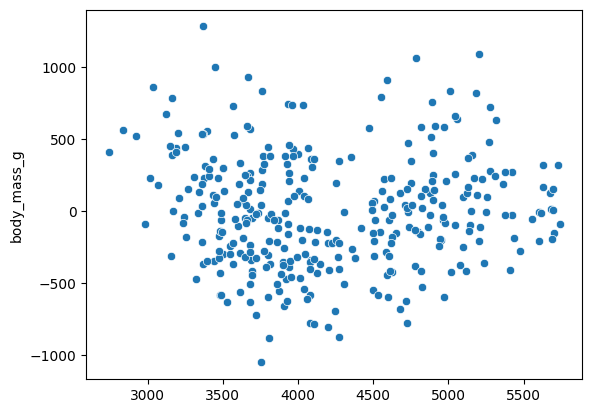

In [9]:
#let's start with a base model for comparison using just the quantitative predictors

model1=LinearRegression()

X = penguins[['bill_depth_mm','bill_length_mm','flipper_length_mm']]
y = penguins['body_mass_g']

# fit the linear regression to the data.
model1.fit(X,y)

# make the residual vs fitted plot
y_hat = model1.predict(X)

# a look at the residual vs fitted plot
sns.scatterplot(x=y_hat, y=y-y_hat)
rmse = root_mean_squared_error(y, y_hat)
print('Root Mean Squared Error:', rmse)

Looks like there is still a bit of curvature there.

In [10]:
x2 = sm.add_constant(X)

#fit linear regression model
model1a = sm.OLS(y, x2).fit()

#view model summary
print(model1a.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     354.9
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          9.26e-103
Time:                        16:03:57   Log-Likelihood:                -2459.8
No. Observations:                 333   AIC:                             4928.
Df Residuals:                     329   BIC:                             4943.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6445.4760    566.13

#### Regression 2: Quantitative Predictors plus Indicators for Species

There is still some apparent curvature in those residuals.  And *bill_length_mm* and *bill_depth_mm* are not discernibly different from zero.

Next we will add the terms for *Adelie* and *Chinstrap* effectively adding a different y-intercept for each species.

Root Mean Squared Error: 311.91393613708215


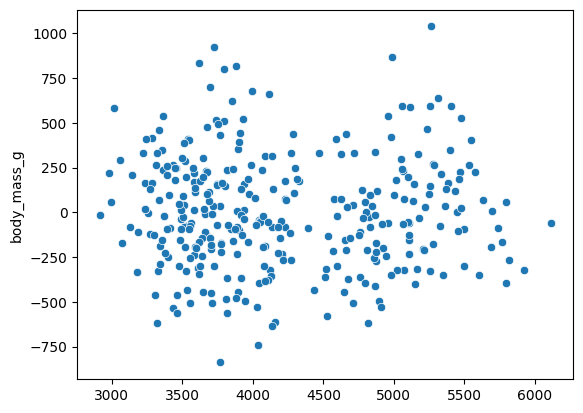

In [11]:

model2=LinearRegression()

X = penguins[['bill_depth_mm','bill_length_mm','flipper_length_mm','Adelie','Chinstrap']]
y = penguins['body_mass_g']

# fit the linear regression to the data.
model2.fit(X,y)

# make the residual vs fitted plot
y_hat = model2.predict(X)
# a look at the residual vs fitted plot
sns.scatterplot(x=y_hat, y=y-y_hat)

rmse = root_mean_squared_error(y, y_hat)
print('Root Mean Squared Error:', rmse)

In [12]:
x2 = sm.add_constant(X)

#fit linear regression model
model2a = sm.OLS(y, x2).fit()

#view model summary
print(model2a.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     369.1
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          4.22e-132
Time:                        16:03:57   Log-Likelihood:                -2384.8
No. Observations:                 333   AIC:                             4782.
Df Residuals:                     327   BIC:                             4805.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3316.8819    567.88

Much to sift through here but some noteworhty things: RMSE has dropped by a good amount, each of the coefficients is distinguishably/significantly different
from zero; the curvature in the residuals is less noticeable.  All of those are good signs for a model.    

#### Regression 3: Quantitative Predictors, Indicator terms, Interaction terms

Root Mean Squared Error: 305.1141170091921


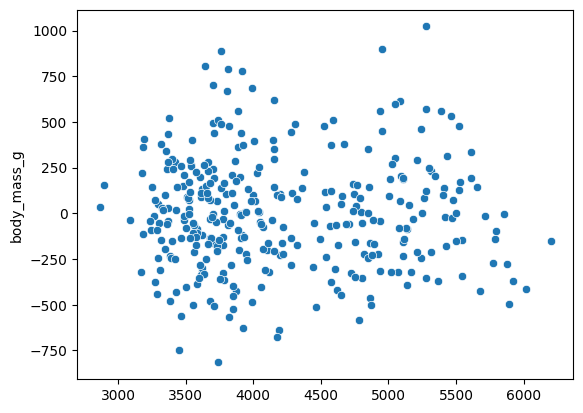

In [13]:
model3=LinearRegression()

X = penguins[['bill_depth_mm','bill_length_mm','flipper_length_mm','Adelie','Chinstrap','billDepth_Adelie',
              'billDepth_Chinstrap','billLength_Adelie','billLength_Chinstrap','flipper_Adelie','flipper_Chinstrap']]
y = penguins['body_mass_g']

# fit the linear regression to the data.
model3.fit(X,y)

# make the residual vs fitted plot
y_hat = model3.predict(X)
# a look at the residual vs fitted plot
sns.scatterplot(x=y_hat, y=y-y_hat)

rmse = root_mean_squared_error(y, y_hat)
print('Root Mean Squared Error:', rmse)

In [14]:
x2 = sm.add_constant(X)

#fit linear regression model
model3a = sm.OLS(y, x2).fit()

#view model summary
print(model3a.summary())

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     173.4
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          7.27e-128
Time:                        16:03:57   Log-Likelihood:                -2377.5
No. Observations:                 333   AIC:                             4779.
Df Residuals:                     321   BIC:                             4825.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4444.4148 

Some notes: RMSE has dropped a small bit; the residuals vs fitted plot is pretty good; but we have many coefficients whose p-value is large.  

### Tasks

1. Interpret the coefficients in *Regression 2*.

2. Using *Regression 2*, how big would the difference in predicted values be between an Adelie penguin and a Gentoo penguin with similar physical measurements?

3. For *Regression 3*, interpret the first 7 coefficients, the coefficients for *const* through *billDepth_Adelie*.

4. Suppose want to find the ''best'' model for predicting body mass given the predictors in *Regression 3*, what model do you investigate next?

5. In some species the males and the females have very different physical profiles, create a model that would have different effects for flipper length for males and females of each species.
